# This is the multiple endurance tool
If it is the first time that you use Jupyter and Conda, you will need to install the package minimalmodbus. Search for the `ANACONDA POWER SHELL` in your system and launch: `pip install minimalmodbus`.

Most important things first: The class Quasar. Feel free to use this class in other scripts. It can be modified, but keep in mind that other users may loose backward compatibility.

**For rokies**, the Quasar class simply defines procedures, communication adresses and some other stuff needed to run the script safely. If you want to take a look on it, it should be placed in the same folder of the script. Otherwise it won't work. If you want to go even further and test some modifications in the class, substitute the following cell by: `%load QuasarClass.py` and run. The class will be shown as is in the python file.

In [1]:
%run -i "QuasarClass.py"


## Endurance in Chademo mode

Discharging...
Data from TEST:
AC voltage: 242.8 V
AC current: 0.3 A
DC voltage: 0.0 V
DC current: -0.7 A
SoC:         91 %
Maximum temperature is:  29ºC

Current state:            2
Reported 2 errors, last was      6s ago with code 0x40400
Running time:      163 s

Generate a failure to stop, i.e. disconnect usb cable (then wait 10s) or trip the AC breaker.
Reset sequence initiated
Reseting in 10s...
Terminating TEST...
Process TEST terminated in error
['Terminated by user']
Charger returned error code 0x40400
Saving file...
Terminated, TEST should be stopped, disconnect mains.


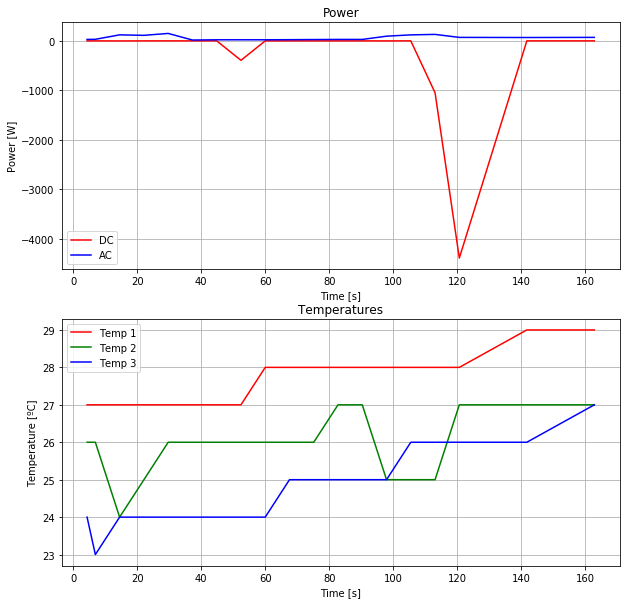

In [2]:
car_operation = {
    'charge_until':80,
    'discharge_until':75,
    'rest_time':60,
    'charge_current':15,
    'discharge_current':15
}

run_in_loop = True

p1 = quasar('TEST', 'COM9', 10)
p1.unlock()
p1.set_chademo_mode()
p1.checklist()

# Run the endurance
from IPython.display import clear_output

state_last = 'null'

# Charger running and SoC updated
if p1.SoC > car_operation['charge_until']:
    state = 'Discharging'
elif p1.SoC < car_operation['discharge_until']:
    state = 'Charging'
else:
    state = 'Charging'

try:
    while (run_in_loop) and (not(p1.is_in_error())):
        starting_time = time.time()
        inhibit_time = True
        if state == 'Charging':
            while (p1.SoC < car_operation['charge_until'] or inhibit_time) and (not(p1.is_in_error())):
                p1.set_op(START)
                p1.set_current(abs(car_operation['charge_current']))
                p1.set_power(100)
                p1.update_values()
                clear_output()
                print("Charging...")
                p1.print_stats()
                print ("\nGenerate a failure to stop, i.e. disconnect usb cable (then wait 10s) or trip the AC breaker.")
                time.sleep(5.0)
                if (time.time() - starting_time) > 20.0:
                    inhibit_time = False
                if (p1.is_in_error()):
                    p1.reset()
            state_last = state
            state = 'Resting'

        elif state == 'Discharging':
            while (p1.SoC > car_operation['discharge_until'] or inhibit_time) and (not(p1.is_in_error())):
                    p1.set_op(START)
                    p1.set_current(-1.0 * abs(car_operation['discharge_current']))
                    p1.set_power(100)
                    p1.update_values()
                    clear_output()
                    print("Discharging...")
                    p1.print_stats()
                    print ("\nGenerate a failure to stop, i.e. disconnect usb cable (then wait 10s) or trip the AC breaker.")
                    time.sleep(5.0)
                    if (time.time() - starting_time) > 20.0:
                        inhibit_time = False
                    if (p1.is_in_error()):
                        p1.reset()
            state_last = state
            state = 'Resting'

        else: #Resting
            start_time = time.time()
            while (time.time() - start_time < car_operation['rest_time']) and (not(p1.is_in_error())):
                    p1.set_op(STOP)
                    p1.set_current(0)
                    p1.set_power(0)
                    p1.update_values()
                    clear_output()
                    print('Resting...')
                    p1.print_stats()
                    print ("\nGenerate a failure to stop, i.e. disconnect usb cable (then wait 10s) or trip the AC breaker.")
                    time.sleep(5.0)
                    if (p1.is_in_error()):
                        p1.reset()            
            if (state_last == 'Charging'):
                state = 'Discharging'
            else:
                state = 'Charging'
except KeyboardInterrupt:
    p1.raise_error("Terminated by user")
    
data = p1.terminate()

# Make some fancy plots
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
time = [element[0] for element in data]
dc_power = [element[6]*element[7] for element in data]
ac_power = [element[3]*element[4] for element in data]
plt.subplot(211)
plt.plot(time, dc_power, 'r', time, ac_power, 'b')
plt.legend(['DC', 'AC'])
plt.xlabel('Time [s]')
plt.ylabel('Power [W]')
plt.yscale('linear')
plt.title('Power')
plt.grid(True)

plt.subplot(212)
temp1 = [element[8] for element in data]
temp2 = [element[9] for element in data]
temp3 = [element[10] for element in data]
plt.plot(time, temp1, 'r',time, temp2, 'g',time, temp3, 'b')
plt.legend(['Temp 1', 'Temp 2', 'Temp 3'])
plt.xlabel('Time [s]')
plt.ylabel('Temperature [ºC]')
plt.yscale('linear')
plt.title('Temperatures')
plt.grid(True)
